In [2]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
import logging
import os
os.chdir(r'E:\AAA_Labwork\Tcell tissues\v2')
import importlib
import warnings
warnings.filterwarnings("ignore")

import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [4]:
#This pallete is for colorblinds
my_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08',
              '#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF',
              '#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A',
              '#D2D30B','#D1BD4F','#06DCF2','#9EDAE5','#517219',
              '#5B43CF','#D92F24','#FFD900','#002F33','#B8A3A3']
donor_palette = ["#cb997e","#ffe8d6","#B2A97D"]
gut_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08',
              '#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF',
              '#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A']

In [5]:
adata = sc.read_h5ad(r"gut_annotated.h5ad")

In [6]:
adata.obs['Donor ID'] = adata.obs['batch']

In [7]:
adata.obs['Donor ID'] = adata.obs['Donor ID'].map({'3':'Donor AJD3280','4':'Donor AJG2309','5':'Donor AJKQ118'})

In [31]:
adata.obs['celltype_lowres'].values.categories

Index(['T Cells', 'NK', 'ILC', 'B Cells', 'Plasma Cells', 'Monocytes',
       'Macrophages', 'Dendritic Cells', 'Endothelial Cells', 'Telocytes',
       'Fibroblastic Reticular Cells', 'Fibroblast', 'Smooth Muscle Cells',
       'Intestinal Epithelial Cells', 'Enteric Glial Cells'],
      dtype='object')

In [32]:
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].astype('category')
ordered_celltype=['T Cells','NK','ILC','B Cells', 'Plasma Cells',
                  'Monocytes','Macrophages','Dendritic Cells', 
                  'Endothelial Cells', 'Telocytes','Fibroblastic Reticular Cells','Fibroblast','Smooth Muscle Cells',
                  'Intestinal Epithelial Cells','Enteric Glial Cells']
adata.obs['celltype_lowres'] = adata.obs['celltype_lowres'].cat.reorder_categories(ordered_celltype)

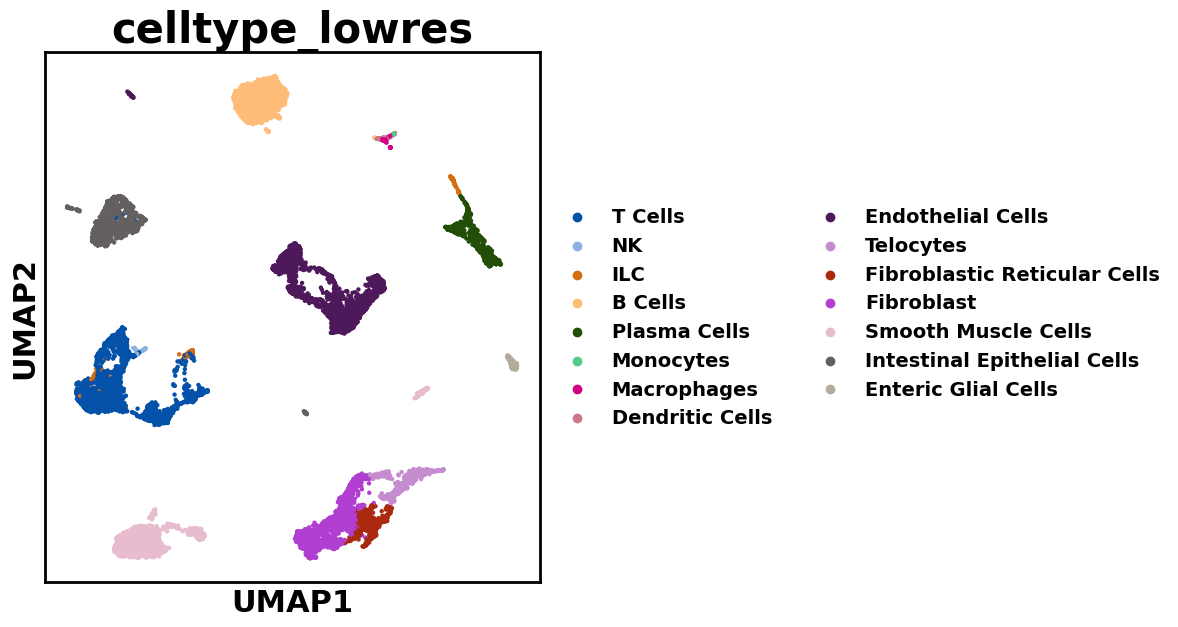

In [36]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = [12,6.5]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})

plt.close()
fig = sc.pl.umap(adata, color = ['celltype_lowres'],
                 size = 40, ncols = 1,palette = gut_palette,
                 return_fig = True, legend_fontsize = 'medium')
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')

plt.tight_layout()
plt.savefig('vis/gut_celltype_low_umap.png',dpi = 300,bbox_inches='tight')

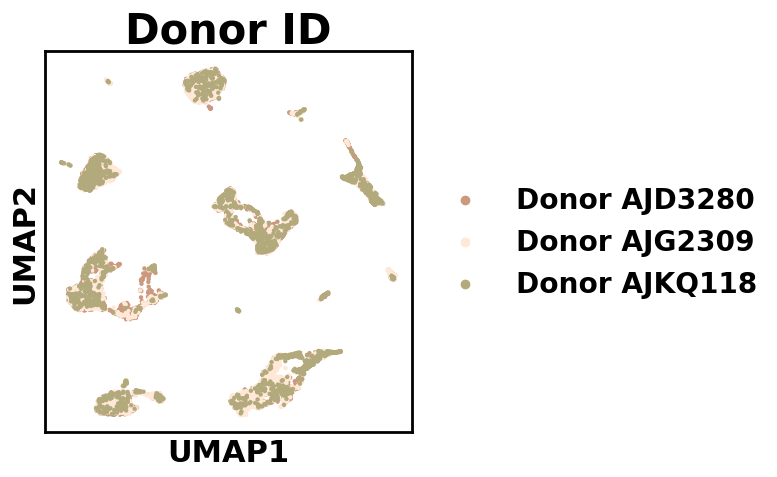

In [ ]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = [8,5]

plt.close()
fig = sc.pl.umap(adata, color = ['Donor ID'],
                 size = 40, ncols = 1,palette = donor_palette,
                 return_fig = True, legend_fontsize = 'x-large')
ax = fig.get_axes()
for i in range(0,len(ax)):
    ax[i].xaxis.label.set_fontsize(22)
    ax[i].xaxis.label.set_fontweight('bold')
    ax[i].yaxis.label.set_fontsize(22)
    ax[i].title.set_fontsize(30)
    ax[i].yaxis.label.set_fontweight('bold')
    ax[i].title.set_fontweight('bold')

plt.tight_layout()
plt.savefig('vis/gut_donor_umap.png',dpi = 300,bbox_inches='tight')

In [37]:
adata3 = adata[adata.obs['batch']=='3']
adata4 = adata[adata.obs['batch']=='4']
adata34 = adata[adata.obs['batch'].isin(['3','4'])]

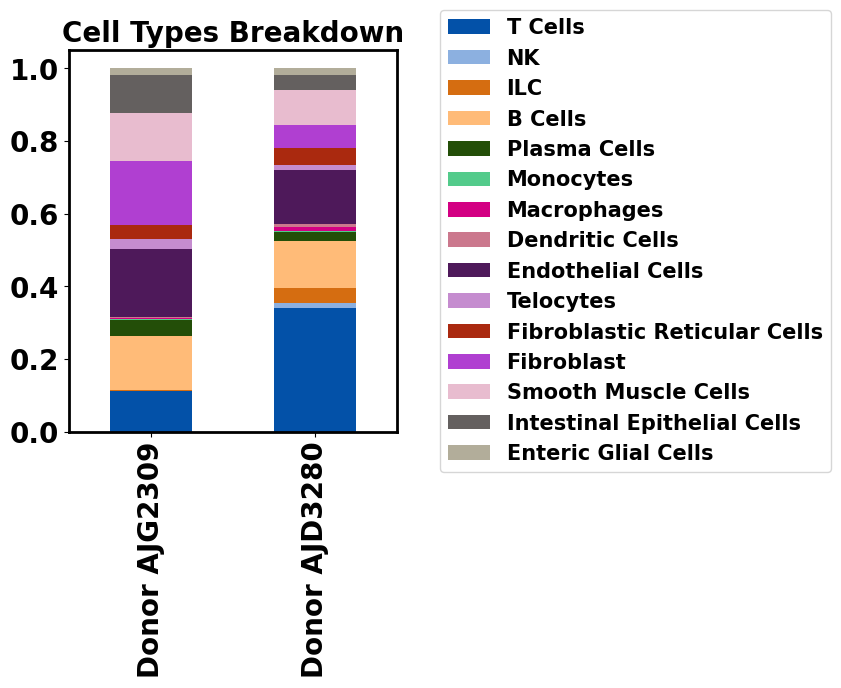

In [38]:
plt.rcParams['figure.figsize'] = [9,7]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})

expand_subtype = pd.DataFrame()
for i in set(adata34.obs['Donor ID']):
    pdtemp = pd.DataFrame(adata34[adata34.obs['Donor ID'] == i,:].obs['celltype_lowres'].value_counts(normalize = True))
    pdtemp = pdtemp.rename({'proportion': i }, axis='columns')
    expand_subtype = pd.concat([expand_subtype, pdtemp], ignore_index=False, axis=1)
expand_subtype = expand_subtype.reindex(index =ordered_celltype)
expand_subtype.transpose().plot.bar(stacked=True,color = adata34.uns['celltype_lowres_colors'],fontsize = 20 ).legend(loc='center left',bbox_to_anchor=(1.1, 0.5),fontsize = 15)
plt.title(label = 'Cell Types Breakdown', fontsize = 20,fontweight = 'bold')
plt.tight_layout()
plt.savefig('vis/gut_celltype_breakdown.png',dpi = 300)

In [39]:
os.chdir(r'E:\AAA_Labwork\Tcell tissues\v2')
adata.write('gut_annotated.h5ad')

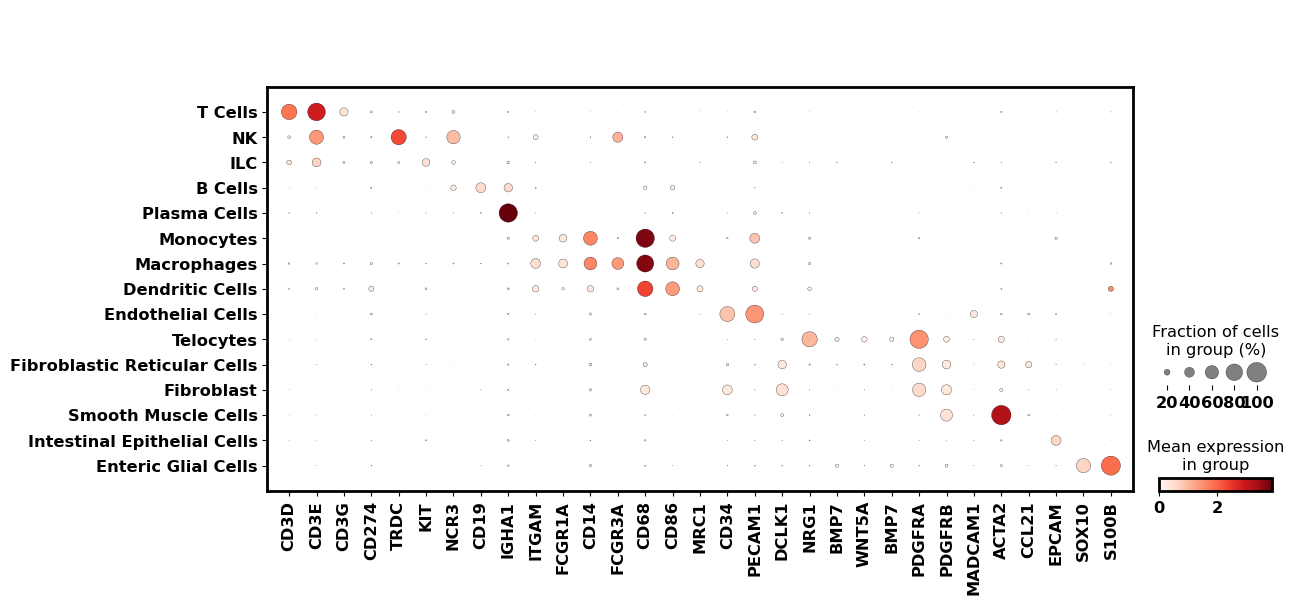

In [ ]:
sc.pl.dotplot(adata, var_names=['CD3D','CD3E','CD3G','CD274','TRDC','KIT','NCR3','CD19','IGHA1','ITGAM','FCGR1A','CD14','FCGR3A','CD68','CD86','MRC1',
                                'CD34','PECAM1','DCLK1','NRG1','BMP7','WNT5A','PDGFRA','PDGFRB','MADCAM1','ACTA2','CCL21','EPCAM','SOX10','S100B'],groupby= 'celltype_lowres')

In [ ]:
gene_list = ['CD3D','CD3E','CD3G','CD274','TRDC','KIT','NCR3','CD19','IGHA1','ITGAM','FCGR1A','CD14','FCGR3A','CD68','CD86','MRC1',
                                'CD34','PECAM1','DCLK1','NRG1','BMP7','WNT5A','PDGFRA','PDGFRB','MADCAM1','ACTA2','CCL21','EPCAM','SOX10','S100B']
df1 = adata[:,gene_list].to_df()
df1['celltype_lowres'] = adata.obs['celltype_lowres']
expression_matrix = df1.groupby('celltype_lowres').mean()

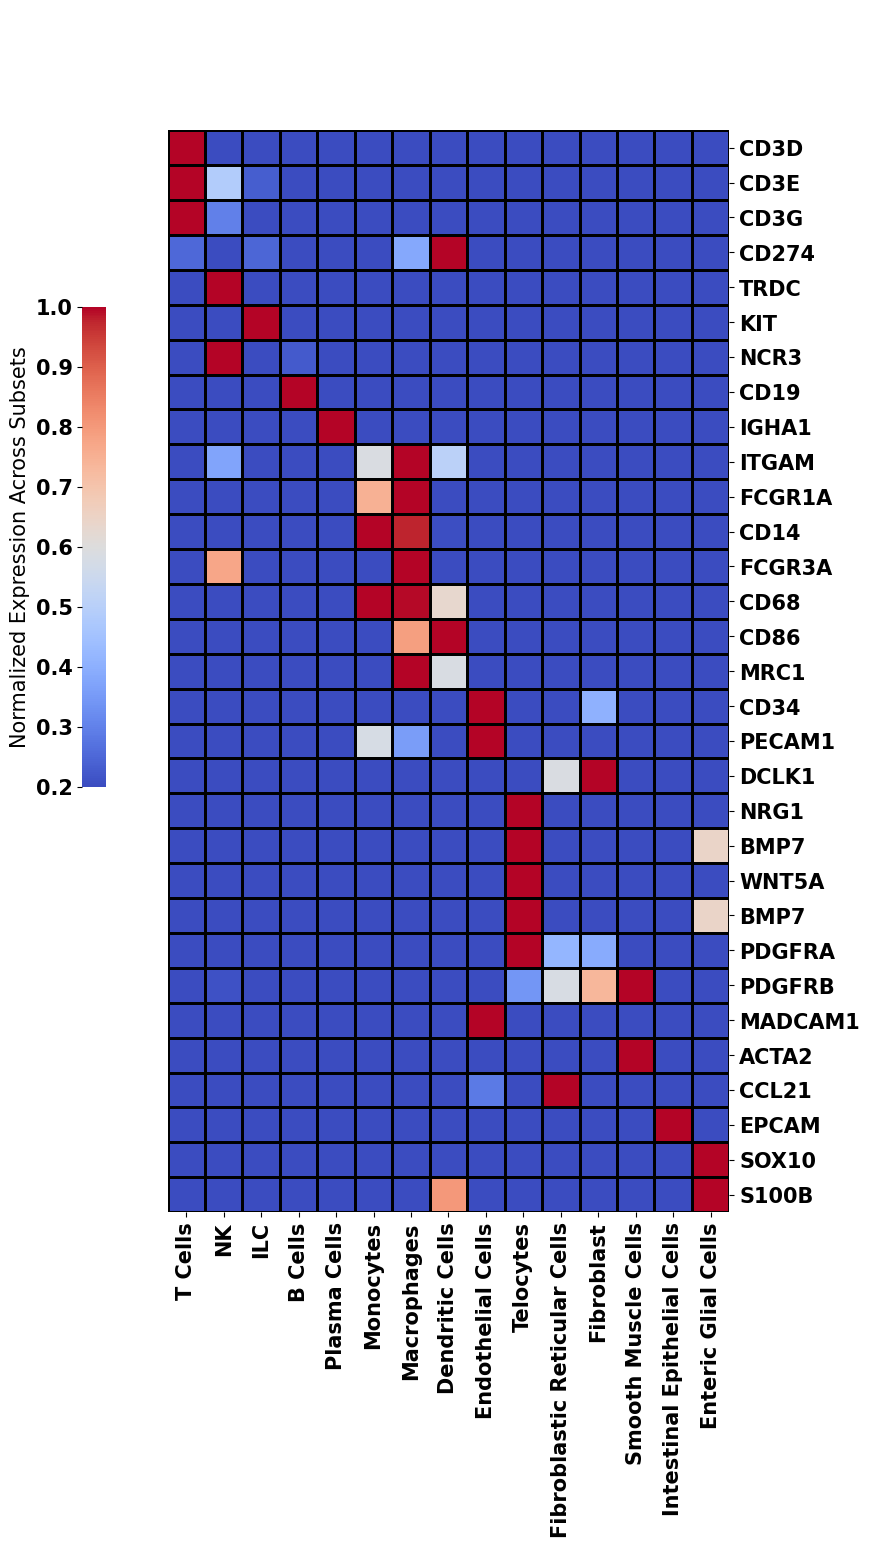

In [42]:
%matplotlib inline
plt.rcParams.update({'font.size': 15, 'font.weight': 'heavy','axes.linewidth':2,'figure.figsize':[8,8]})
#plt.rcParams.update(plt.rcParamsDefault)
kwargs = {'cmap': 'coolwarm'}
clustergrid = sns.clustermap(expression_matrix.T,figsize = (8,16),linewidths=2,standard_scale=0,
               linecolor = 'k',dendrogram_ratio = 0.1, colors_ratio = 0.5,vmax = 1,vmin = 0.2,
               row_cluster = False,col_cluster = False,cbar_kws={'label': 'Normalized Expression Across Subsets','location':"left"},
               **kwargs)
for a in clustergrid.ax_col_dendrogram.collections:
        a.set_linewidth(2)
clustergrid.ax_cbar.set_position([0, 0.5, 0.03, 0.3])

axs = clustergrid.fig.get_axes()
for j in range(0,len(axs)): 
    axs[j].set_xlabel('')

plt.savefig('vis/gut_heatmap.png',dpi = 300,bbox_inches='tight')